In [699]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from scipy.signal import savgol_filter

In [700]:
from summer2 import CompartmentalModel, Stratification, Multiply
from summer2.parameters import Parameter
from summer2.functions import get_piecewise_scalar_function

**Model 2: SEIQR (Stratified Infectious Compartment)**

In [777]:
def build_model():
    m = CompartmentalModel([0,500], ["S","E","I","Q","R"],"I",ref_date=datetime(2020,6,1))
    m.set_initial_population({"S": 13781001.0, "E": 832.0 , "I": 1153.0, "Q": 3622.0, "R": 14178.0})
    m.add_infection_frequency_flow("infection", get_piecewise_scalar_function([Parameter("breakpt1"),Parameter("breakpt2")], [Parameter("rate1"),Parameter("multiplier1")*Parameter("rate1"),Parameter("multiplier2")*Parameter("rate1")]),"S","E") 
    m.add_transition_flow("progression", 0.2,"E","I")
    m.add_transition_flow("notification", Parameter("detection_rate"),"I","Q")
    m.add_transition_flow("recovery_from_Q", 0.0714,"Q","R") 
    m.add_transition_flow("recovery__from_I", 0.0714,"I","R") 
    #m.add_death_flow("infection_death", Parameter("death_rate"), "I")
    m.request_output_for_flow("infection", "infection")
    m.request_output_for_flow("notification", "notification")
    #m.request_output_for_flow("infection_death", "infection_death")
    #m.request_cumulative_output(name="deaths_cumulative", source="infection_death")
    m.request_output_for_compartments(name="active", compartments=["Q"])

    strata = ["asymptomatic", "symptomatic"]
    strat = Stratification(name="severity", strata=strata, compartments=['I'])

    strat.set_population_split({"asymptomatic": 0.18, "symptomatic": 0.82})

    strat.set_flow_adjustments("progression", {
    "asymptomatic": None,
    "symptomatic": Multiply(Parameter("symp_prop")),
    })

    strat.set_flow_adjustments("notification", {
    "asymptomatic": Multiply(Parameter("asymp_det")),
    "symptomatic": None,
    })

    #strat.set_flow_adjustments("infection_death", {
    #"asymptomatic": Multiply(Parameter("asymp_death")),
    #"symptomatic": None,
    #})

    return m, strat

In [778]:
m, strat = build_model()
m.stratify_with(strat)

/var/folders/58/qy67y27x0jsd0h0bx4dmp2yw0000gn/T/ipykernel_23199/313886924.py:4: DeprecationWarning:

This method is deprecated and scheduled for removal, use get_piecewise_function instead



In [779]:
#parameters = {"breakpt1": 63, "breakpt2": 79, "rate1": 0.3, "multiplier1": 0.5, "multiplier2": 0.9, "detection_rate": 0.1, "symp_prop": 4.5, "asymp_det": 0.2, "death_rate": 0.01, "asymp_death": 0.3}
parameters = {"breakpt1": 63, "breakpt2": 79, "rate1": 0.3, "multiplier1": 0.5, "multiplier2": 0.9, "detection_rate": 0.1, "symp_prop": 4.5, "asymp_det": 0.2}

In [780]:
m.run(parameters)

In [781]:
fig = px.line(m.get_outputs_df())
fig.show()

/Users/mark/miniconda3/envs/summer2/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [782]:
fig = px.line(m.get_derived_outputs_df())
fig.show()

/Users/mark/miniconda3/envs/summer2/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [783]:
df=pd.read_excel(io='InfectionsData_060120_093020.xlsx',index_col=0)
notification_data = df["NOTIFICATIONS"]
death_data = df["CUMULATIVE DEATHS"]

In [784]:
notification_smoothed = savgol_filter(notification_data, window_length=12, polyorder=2)
notification_smoothed = pd.DataFrame(notification_smoothed, index=notification_data.keys())
notification_smoothed = notification_smoothed[0]

In [785]:
fig = px.line(notification_data)
fig = fig.add_trace(go.Scatter(x = notification_smoothed.keys(), y=notification_smoothed, name = "smoothed"))
fig.show()

/Users/mark/miniconda3/envs/summer2/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [786]:
notification_target = notification_smoothed[:90]
#death_data_cal = death_data[:90:2]

In [787]:
fig = px.scatter(notification_target)
fig.show()
#death_data_cal.plot(style='.')

/Users/mark/miniconda3/envs/summer2/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



**Calibration**

In [788]:
# Targets represent data we are trying to fit to
from estival import targets as est

# We specify parameters using (Bayesian) priors
from estival import priors as esp

# Finally we combine these with our summer2 model in a BayesianCompartmentalModel (BCM)
from estival.model import BayesianCompartmentalModel

In [789]:
targets = [
    #est.NormalTarget("notification", notification_data_cal, np.std(notification_data_cal) * 0.1)
    est.TruncatedNormalTarget("notification", notification_target, (0.0,np.inf),
        esp.UniformPrior("notification_dispersion",(0.1, notification_target.max()*0.1))),
    #est.NormalTarget("deaths_cumulative", death_data_cal, np.std(death_data_cal) * 0.1)
]

In [790]:
priors = [
    esp.TruncNormalPrior("breakpt1",63.0,2.0,(59.0,67.0)),
    esp.TruncNormalPrior("breakpt2",79.0,2.0,(75.0,83.0)),
    esp.UniformPrior("rate1", (0,0.5)),
    esp.UniformPrior("multiplier1", (0,1)),
    esp.UniformPrior("multiplier2", (0.6,1)),
    esp.UniformPrior("detection_rate", (0,0.5)),
    esp.UniformPrior("symp_prop", (1,6)),
    esp.UniformPrior("asymp_det", (0,1)),
    #esp.UniformPrior("death_rate", (0,0.1)),
    #esp.UniformPrior("asymp_death", (0,0.7)),
]

In [791]:
defp = parameters

In [792]:
bcm = BayesianCompartmentalModel(m, defp, priors, targets)
from estival.wrappers import pymc as epm
import pymc as pm

In [793]:
with pm.Model() as model:

    # This is all you need - a single call to use_model
    variables = epm.use_model(bcm)

    # The log-posterior value can also be output, but may incur additional overhead
    # Use jacobian=False to get the unwarped value (ie just the 'native' density of the priors
    # without transformation correction factors)
    # pm.Deterministic("logp", model.logp(jacobian=False))

    # Now call a sampler using the variables from use_model
    # In this case we use the Differential Evolution Metropolis sampler
    # See the PyMC docs for more details
    idata = pm.sample(step=[pm.DEMetropolis(variables)], draws=20000, tune=0,cores=4,chains=12)

Population sampling (12 chains)
DEMetropolis: [breakpt1, breakpt2, rate1, multiplier1, multiplier2, detection_rate, symp_prop, asymp_det, notification_dispersion]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


python(41653) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
python(41691) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
python(41727) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
python(41762) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
python(41797) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
python(41834) MallocStackLogging: can't turn off malloc

Sampling 12 chains for 0 tune and 20_000 draw iterations (0 + 240_000 draws total) took 115 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Visualizing Outputs**

In [794]:
import arviz as az

In [795]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
breakpt1,63.088,1.660,60.139,66.288,0.048,0.034,1183.0,1506.0,1.01
breakpt2,78.814,1.673,75.445,81.672,0.048,0.034,1182.0,1766.0,1.01
rate1,0.263,0.070,0.164,0.392,0.004,0.003,393.0,594.0,1.03
multiplier1,0.729,0.185,0.395,1.000,0.008,0.006,467.0,332.0,1.02
multiplier2,0.777,0.109,0.600,0.960,0.003,0.002,1022.0,1597.0,1.02
detection_rate,0.186,0.119,0.009,0.402,0.006,0.004,383.0,288.0,1.03
symp_prop,3.083,1.375,1.014,5.438,0.041,0.029,1070.0,1438.0,1.01
asymp_det,0.423,0.271,0.000,0.882,0.010,0.007,633.0,768.0,1.02
notification_dispersion,217.032,40.922,141.968,272.437,1.141,0.818,1194.0,1769.0,1.01


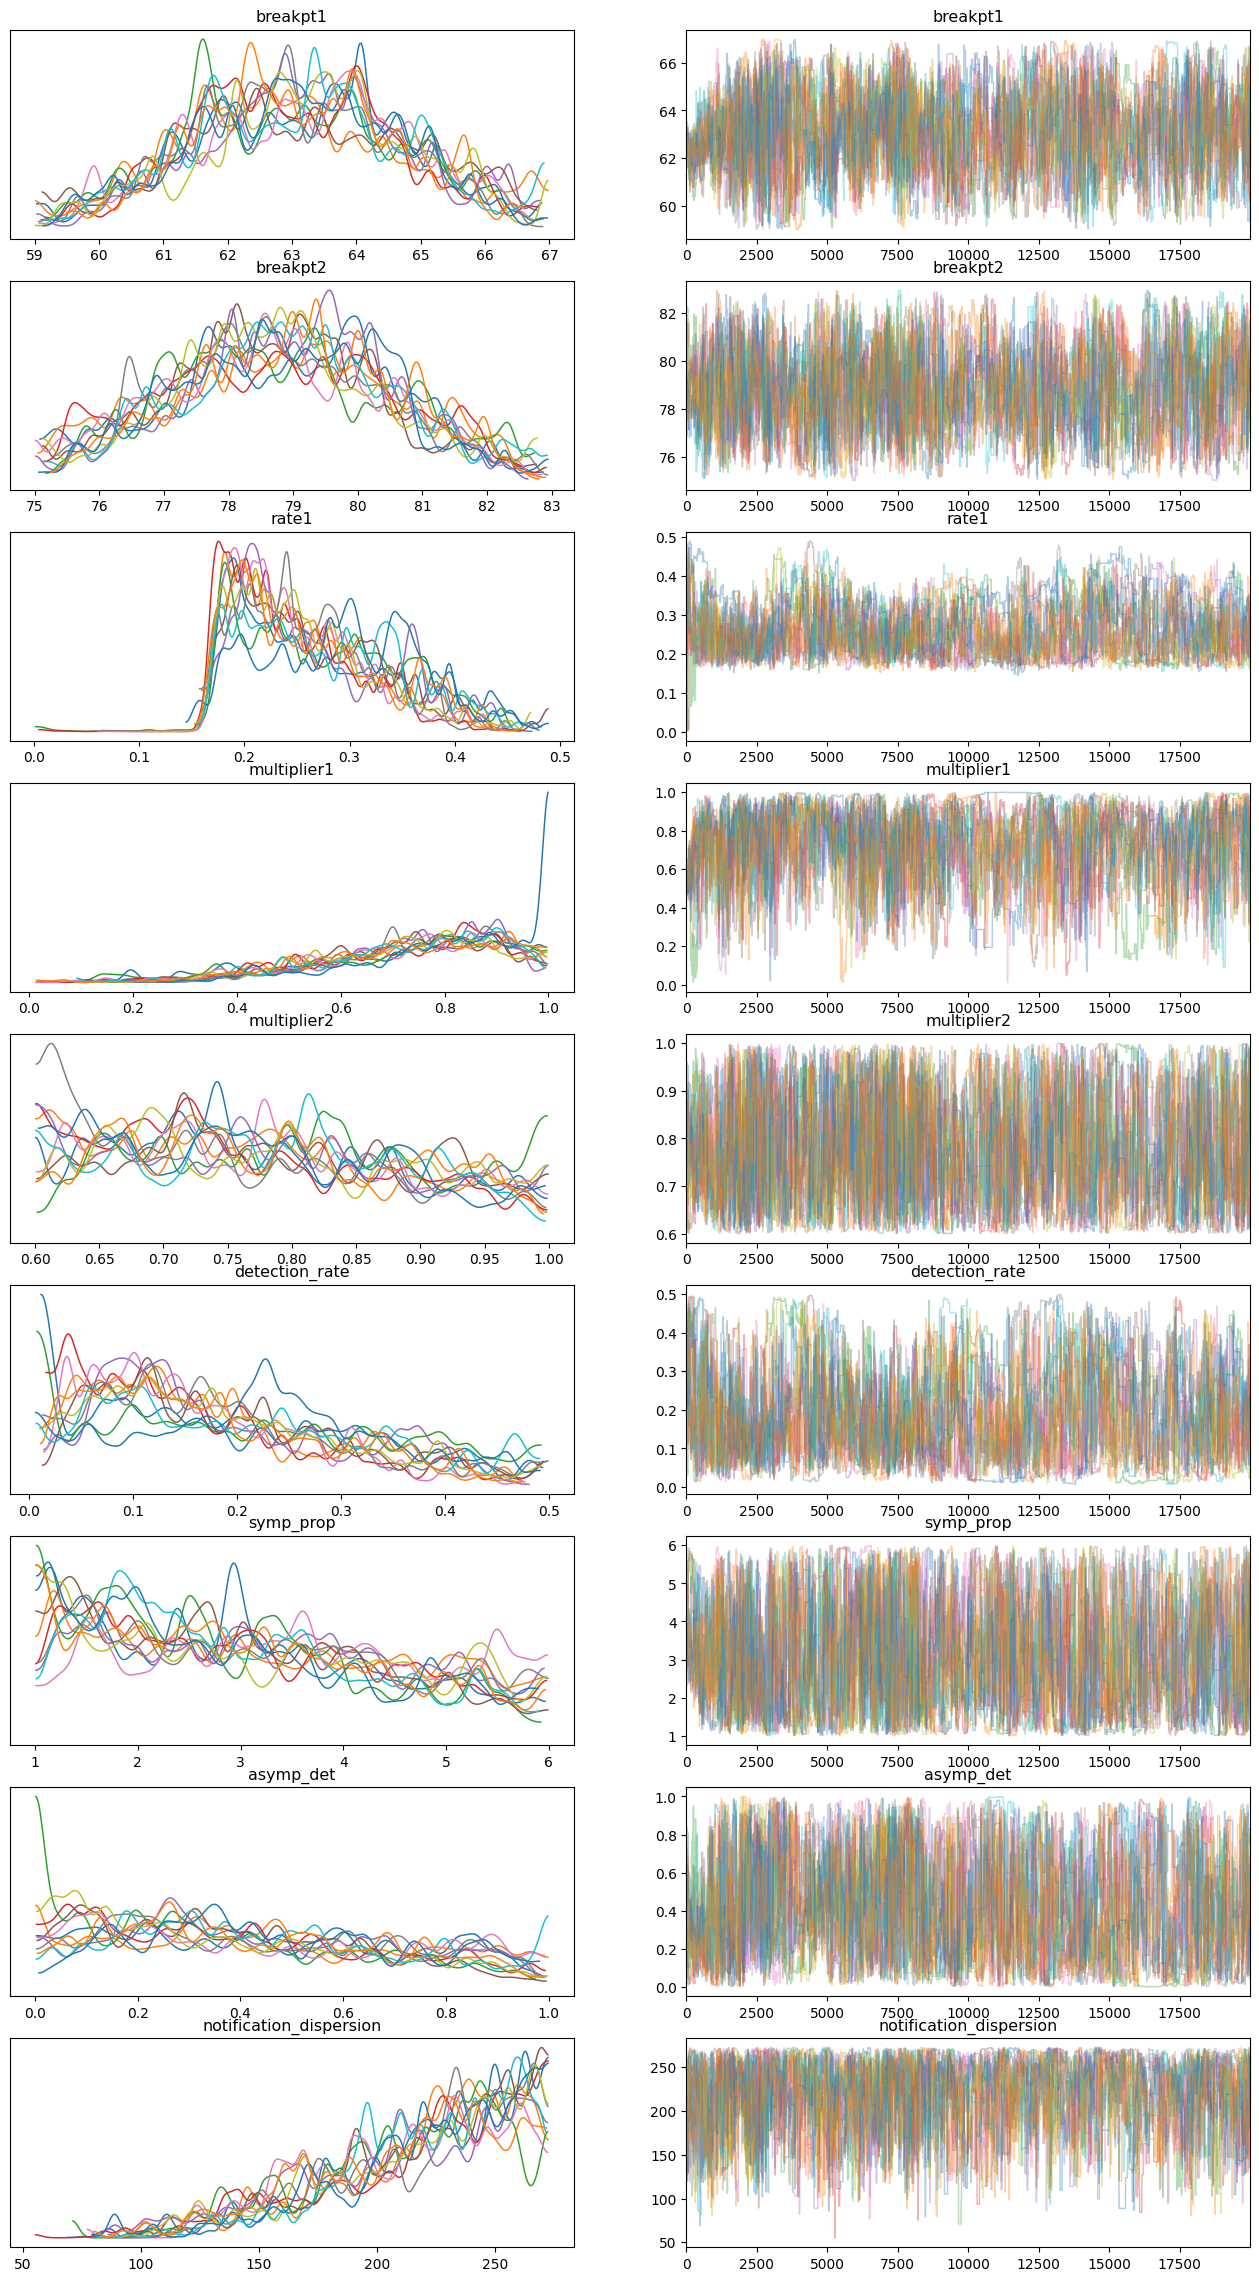

In [796]:
az.plot_trace(idata, figsize=(16,3.2*len(idata.posterior)),compact=False);#, lines=[("m", {}, mtrue), ("c", {}, ctrue)]);

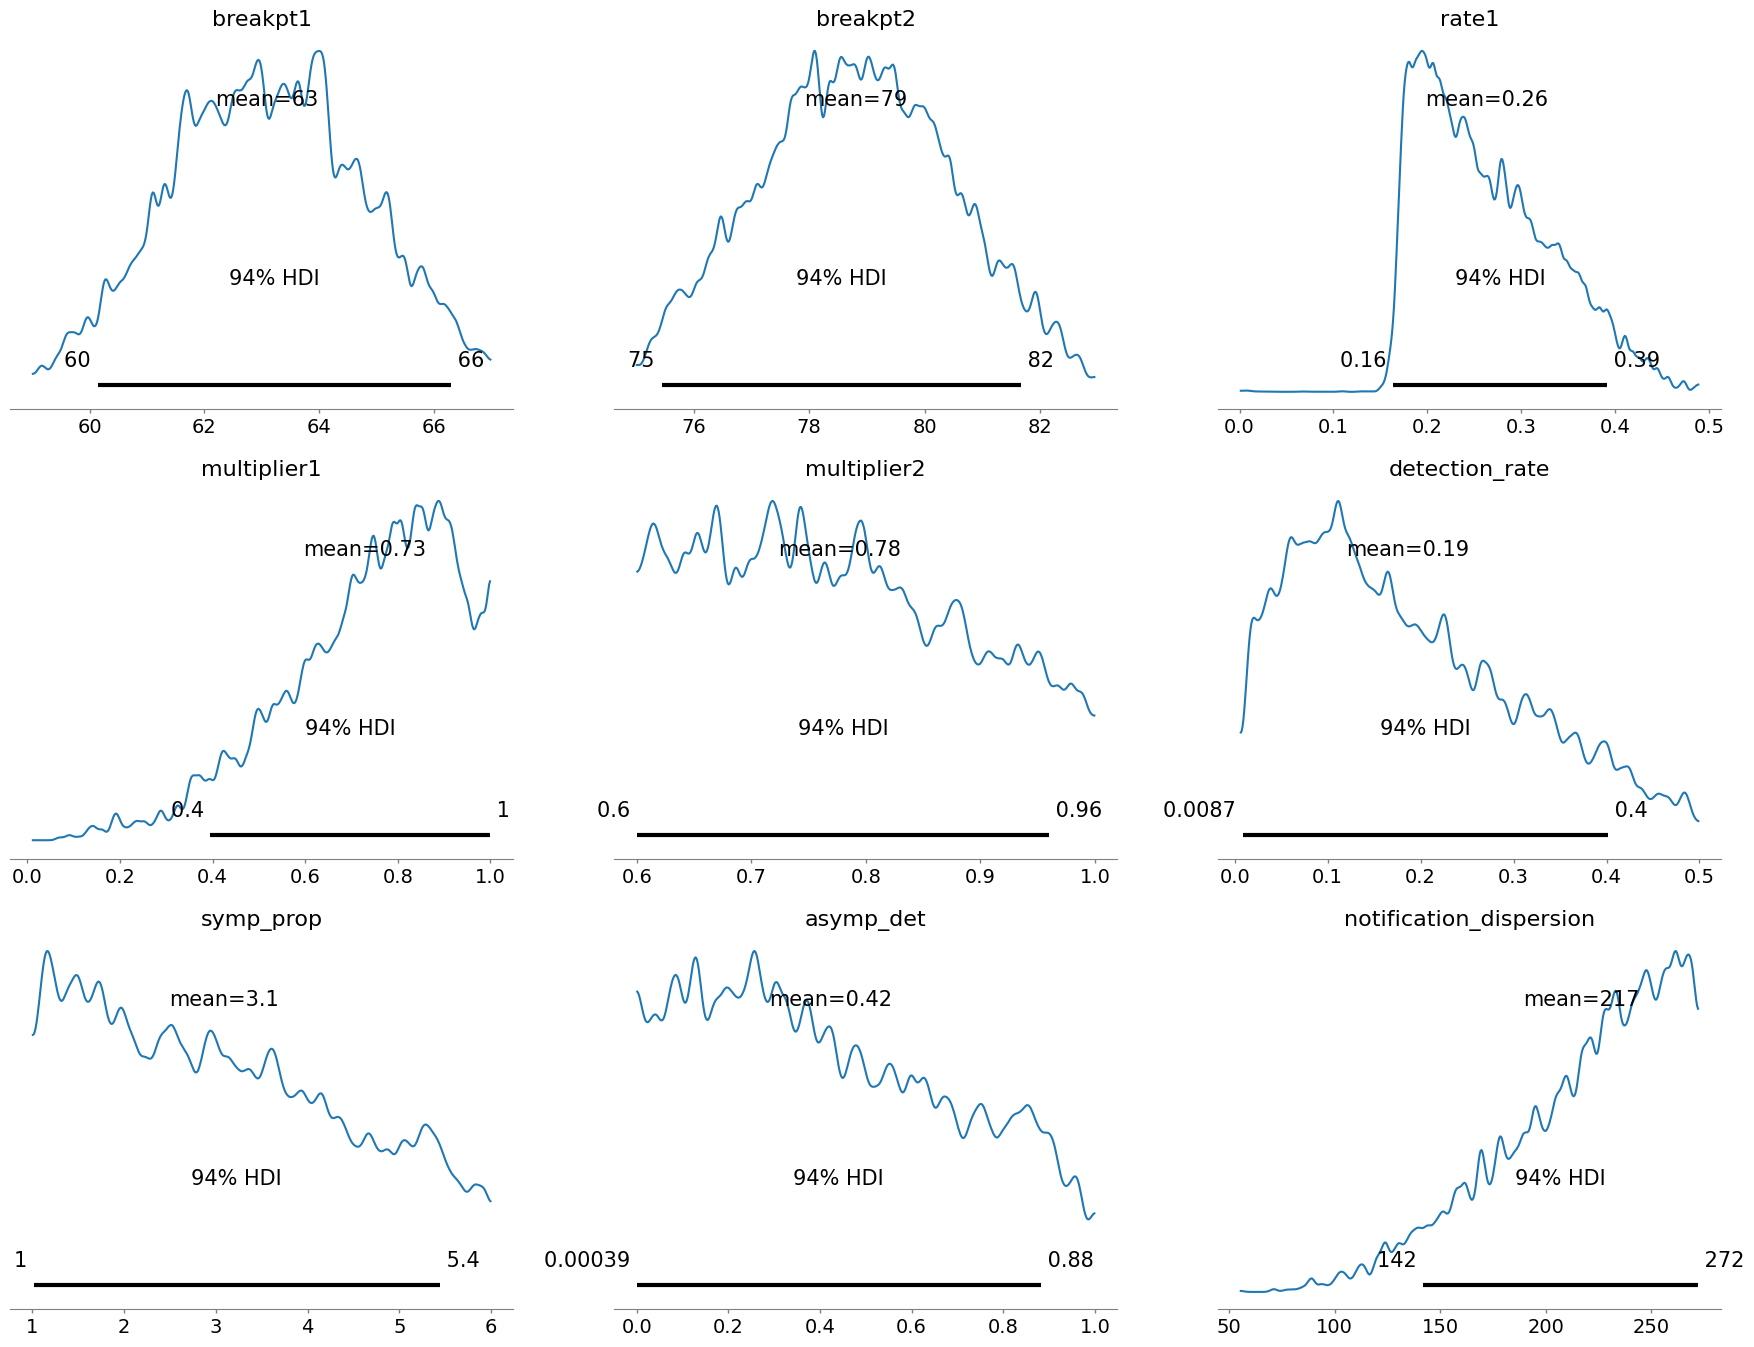

In [797]:
az.plot_posterior(idata);

**Obtaining Likelihood**

In [798]:
from estival.sampling.tools import likelihood_extras_for_idata

In [799]:
likelihood_df = likelihood_extras_for_idata(idata, bcm)

<Axes: xlabel='draw'>

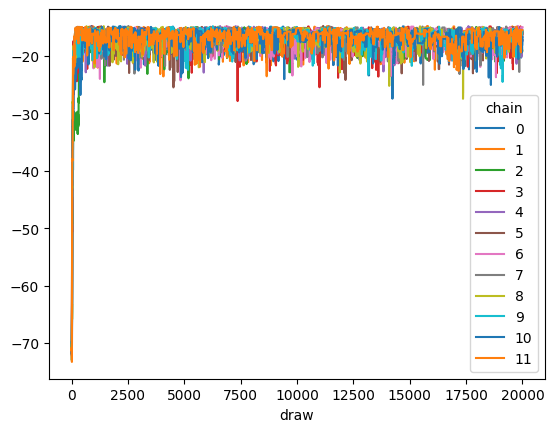

In [800]:
ldf_pivot = likelihood_df.reset_index(level="chain").pivot(columns=["chain"])

ldf_pivot["logposterior"].plot()

In [801]:
# Sort this DataFrame by logposterior to obtain the MAP index
ldf_sorted = likelihood_df.sort_values(by="logposterior",ascending=False)

# Extract the parameters from the calibration samples
map_params = idata.posterior.to_dataframe().loc[ldf_sorted.index[0]].to_dict()

map_params

{'breakpt1': 63.625862873053315,
 'breakpt2': 79.63599633609473,
 'rate1': 0.24957491153888078,
 'multiplier1': 0.6825090543965274,
 'multiplier2': 0.6064505472105696,
 'detection_rate': 0.1607094600589305,
 'symp_prop': 1.0085692571272336,
 'asymp_det': 0.4137503149365626,
 'notification_dispersion': 175.6702184926763}

In [802]:
bcm.loglikelihood(**map_params), ldf_sorted.iloc[0]["loglikelihood"]

(Array(-6.64873977, dtype=float64), -6.648739771094259)

In [803]:
map_res = bcm.run(map_params)

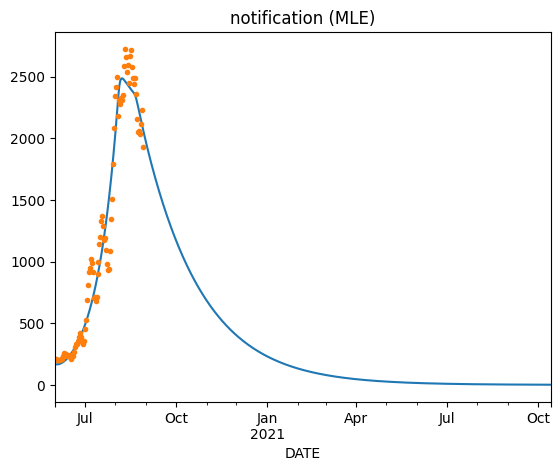

In [804]:
variable = "notification"

pd.Series(map_res.derived_outputs[variable]).plot(title = f"{variable} (MLE)")
bcm.targets[variable].data.plot(style='.');

**Compare with Actual Data**

In [805]:
variable = "notification"

fig = go.Figure()
fig = fig.add_trace(go.Scatter(x = map_res.derived_outputs[variable].keys(), y = map_res.derived_outputs[variable], name = "MLE"))
fig = fig.add_trace(go.Scatter(x = notification_target.keys(), y = notification_target, name = "data"))
fig = fig.add_trace(go.Scatter(x = notification_smoothed[89:].keys(), y = notification_smoothed[89:], name = "data"))
fig.show()

**Uncertainty Sampling**

In [806]:
sample_idata = az.extract(idata, num_samples = 400)
samples_df = sample_idata.to_dataframe().drop(columns=["chain","draw"])

In [807]:
from estival.utils.parallel import map_parallel

In [808]:
def run_sample(idx_sample):
    idx, params = idx_sample
    return idx, bcm.run(params)

In [809]:
sample_res = map_parallel(run_sample, samples_df.iterrows(), n_workers=4)

python(42138) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
python(42175) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
python(42210) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
python(42245) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [810]:
import xarray as xr

In [811]:
xres = xr.DataArray(np.stack([r.derived_outputs for idx, r in sample_res]),
                    dims=["sample","time","variable"])
xres = xres.assign_coords(sample=sample_idata.coords["sample"],
                          time=map_res.derived_outputs.index, variable=map_res.derived_outputs.columns)

In [812]:
# Set some quantiles to calculate
quantiles = (0.01,0.05,0.10,0.25,0.5,0.75,0.9,0.95,0.99)

# Generate a new DataArray containing the quantiles
xquantiles = xres.quantile(quantiles,dim=["sample"])

In [813]:
# Extract these values to a pandas DataFrame for ease of plotting

uncertainty_df = xquantiles.to_dataframe(name="value").reset_index().set_index("time").pivot(columns=("variable","quantile"))["value"]

In [814]:
#Using plotly

variable = "notification"
m = map_res.derived_outputs[variable]
fig = go.Figure()
fig = px.line(uncertainty_df[variable])
fig = fig.add_trace(go.Scatter(x = m.keys(), y = m, name = "MLE"))
fig = fig.add_trace(go.Scatter(x = notification_data[:90].keys(), y = notification_data[:90], name = "data"))
fig = fig.add_trace(go.Scatter(x = notification_data[89:].keys(), y = notification_data[90:], name = "data"))
fig = fig.add_trace(go.Scatter(x = notification_smoothed.keys(), y = notification_smoothed, name = "smoothed"))
fig.show()

/Users/mark/miniconda3/envs/summer2/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

